In [23]:
import numpy as np
import re
from csv import DictReader


fileLoc = "/home/vamsi/Downloads/fnc-1-baseline/fnc-1/"

text = []
with open(fileLoc+"words.txt") as f:
    text = f.read()
    text = re.sub('"','',text)
    text = re.sub(' ','',text)
    text = re.sub('\n','',text)
    text = text.split(',')
    
def readDict(fname):
        rows = []
        with open(fname, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)
        return rows
    


### Count Vectorization

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

numFeatures = 5000

countVectorizer = CountVectorizer(max_features=numFeatures, stop_words=text)

newsBody = readDict(fileLoc+"train_bodies.csv")

instances = readDict(fileLoc+"train_stances.csv")

headers = {}
newsBodies = {}

for instance in instances:
    if instance['Headline'] not in headers:
        head_id = len(headers)
        headers[instance['Headline']] = head_id
    instance['Body ID'] = int(instance['Body ID'])
#print(heads)

for body in newsBody:
    newsBodies[int(body['Body ID'])] = body['articleBody']


In [3]:
heads = []
heads_track = {}
bodies = []
bodies_track = {}
body_ids = []
id_ref = {}
train_set = []
train_stances = []
cos_track = {}
test_heads = []
test_heads_track = {}
test_bodies = []
test_bodies_track = {}
test_body_ids = []
head_tfidf_track = {}
body_tfidf_track = {}

# Identify unique heads and bodies
for instance in instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        heads.append(head)
        heads_track[head] = 1
    if body_id not in bodies_track:
        bodies.append(newsBodies[body_id])
        bodies_track[body_id] = 1
        body_ids.append(body_id)




In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
bow = countVectorizer.fit_transform(heads + bodies) 

### tfreq

In [5]:
tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray() 

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=numFeatures, stop_words=text).fit(heads + bodies + test_heads + test_bodies)  # Train and test sets

print(type(tfreq))

<class 'numpy.ndarray'>


In [7]:
        # Create reference dictionary
id_ref = {}
for i, elem in enumerate(heads + body_ids):
    id_ref[elem] = i
mapLabels = {'agree': 0, 'disagree': 1, 'discuss': 0, 'unrelated': 1}



In [8]:
print(len(bodies))
print(len(newsBodies))

1683
1683


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for instance in instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    head_tf = tfreq[id_ref[head]].reshape(1, -1)
    body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
    if head not in head_tfidf_track:
        head_tfidf = tfidf_vectorizer.transform([head]).toarray()
        head_tfidf_track[head] = head_tfidf
    else:
        head_tfidf = head_tfidf_track[head]
    if body_id not in body_tfidf_track:
        print(body_id)
        body_tfidf = tfidf_vectorizer.transform([newsBodies[body_id]]).toarray()
        body_tfidf_track[body_id] = body_tfidf
    else:
        body_tfidf = body_tfidf_track[body_id]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    train_set.append(feat_vec)
    train_stances.append(mapLabels[instance['Stance']])

In [ ]:
max_id = 0
for i in instances:
    print(i['Body ID'])
    if max_id<i['Body ID']:
        max_id = i['Body ID']
        
print(max_id)
    

In [12]:
import tensorflow as tf

hidden_size = 100
target_size = 4
l2_alpha = 0.00001

feature_size = len(train_set[0])
features_pl = tf.placeholder(tf.float32, [None, feature_size], 'features')
stances_pl = tf.placeholder(tf.int64, [None], 'stances')
keep_prob_pl = tf.placeholder(tf.float32)

# Infer batch size
batch_size = tf.shape(features_pl)[0]

# Define multi-layer perceptron
hidden_layer = tf.nn.dropout(tf.nn.relu(tf.contrib.layers.linear(features_pl, hidden_size)), keep_prob=keep_prob_pl)
logits_flat = tf.nn.dropout(tf.contrib.layers.linear(hidden_layer, target_size), keep_prob=keep_prob_pl)
logits = tf.reshape(logits_flat, [batch_size, target_size])

# Define L2 loss
tf_vars = tf.trainable_variables()
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf_vars if 'bias' not in v.name]) * l2_alpha

# Define overall loss
loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=stances_pl) + l2_loss)
#print loss

# Define prediction
softmaxed_logits = tf.nn.softmax(logits)
predict = tf.arg_max(softmaxed_logits, 1)


/home/vamsi/miniconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Instructions for updating:
Use `argmax` instead


In [13]:
# Initialise

newsBody = readDict(fileLoc+"competition_test_bodies.csv")

test_instances = readDict(fileLoc+"competition_test_stances_unlabeled.csv")

headers = {}
bodies = {}

for instance in test_instances:
    if instance['Headline'] not in headers:
        head_id = len(headers)
        headers[instance['Headline']] = head_id
    instance['Body ID'] = int(instance['Body ID'])
#print(heads)

for body in newsBody:
    bodies[int(body['Body ID'])] = body['articleBody']



for instance in test_instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in test_heads_track:
        test_heads.append(head)
        test_heads_track[head] = 1
    if body_id not in test_bodies_track:
        test_bodies.append(bodies[body_id])
        test_bodies_track[body_id] = 1
        test_body_ids.append(body_id)

test_set = []
heads_track = {}
bodies_track = {}
cos_track = {}

# Process test set
for instance in test_instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        head_bow = countVectorizer.transform([head]).toarray()
        head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
        head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
        heads_track[head] = (head_tf, head_tfidf)
    else:
        head_tf = heads_track[head][0]
        head_tfidf = heads_track[head][1]
    if body_id not in bodies_track:
        body_bow = countVectorizer.transform([bodies[body_id]]).toarray()
        body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
        body_tfidf = tfidf_vectorizer.transform([bodies[body_id]]).toarray().reshape(1, -1)
        bodies_track[body_id] = (body_tf, body_tfidf)
    else:
        body_tf = bodies_track[body_id][0]
        body_tfidf = bodies_track[body_id][1]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    test_set.append(feat_vec)



In [33]:
import random
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90
train_keep_prob = 0.6
n_train = len(instances)
opt_func = tf.train.AdamOptimizer(learn_rate)
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tf_vars), clip_ratio)
opt_op = opt_func.apply_gradients(zip(grads, tf_vars))
r = random.Random()
step = []
loss_minibatch = []
new_loss_minibatch = []
# Perform training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        total_loss = 0
        indices = list(range(n_train))
        r.shuffle(indices)

        for i in range(n_train // batch_size_train):
            batch_indices = indices[i * batch_size_train: (i + 1) * batch_size_train]
            batch_features = [train_set[i] for i in batch_indices]
            batch_stances = [train_stances[i] for i in batch_indices]

            batch_feed_dict = {features_pl: batch_features, stances_pl: batch_stances, keep_prob_pl: train_keep_prob}
            _, current_loss = sess.run([opt_op, loss], feed_dict=batch_feed_dict)
            total_loss += current_loss
            #if (i == 0): ## info will be printed every 1000th time
        print(epoch)
        step.append(epoch)
        print("Minibatch loss at step %d: %f" % (epoch, total_loss))
        new_loss_minibatch.append(total_loss)
                #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                #accuracy_minibatch.append(accuracy(predictions, batch_labels))
                #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
                #accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
        test_feed_dict = {features_pl: test_set, keep_prob_pl: 1.0}
    test_pred = sess.run(predict, feed_dict=test_feed_dict)


0
Minibatch loss at step 0: 28592.050797
1
Minibatch loss at step 1: 19665.807693
2
Minibatch loss at step 2: 18241.773804
3
Minibatch loss at step 3: 18162.739151
4
Minibatch loss at step 4: 17583.803131
5
Minibatch loss at step 5: 17519.209290
6
Minibatch loss at step 6: 17280.554565
7
Minibatch loss at step 7: 17433.056839
8
Minibatch loss at step 8: 17145.055649
9
Minibatch loss at step 9: 17057.167542
10
Minibatch loss at step 10: 16939.325546
11
Minibatch loss at step 11: 17055.983521
12
Minibatch loss at step 12: 17136.113556
13
Minibatch loss at step 13: 17258.212128
14
Minibatch loss at step 14: 17002.203018
15
Minibatch loss at step 15: 17012.628387
16
Minibatch loss at step 16: 17285.815308
17
Minibatch loss at step 17: 16980.729691
18
Minibatch loss at step 18: 16844.980072
19
Minibatch loss at step 19: 16725.020966
20
Minibatch loss at step 20: 16859.015015
21
Minibatch loss at step 21: 16893.111359
22
Minibatch loss at step 22: 17204.124893
23
Minibatch loss at step 23: 1

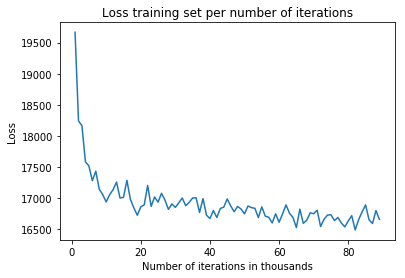

In [43]:

import matplotlib.pyplot as plt
#import seaborn as sns

#plt.figure(figsize=(20, 4))

#plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],new_loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations in thousands')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')
plt.show()

### Testing

In [44]:
actualLabels = readDict(fileLoc+"competition_test_stances.csv")

actualStances = []

for r in actualLabels:
   # print(r['Stance'])
    #print(label_ref[r])
    actualStances.append(mapLabels[r['Stance']])
    
count =0

for i in range(len(actualStances)):
    if actualStances[i] == test_pred[i]:
        count += 1
        
print(count/len(actualStances))

0.925943414787707


In [30]:
0.9294062094203754 - 8000
0.9283437610671703 - 5000


0.9294062094203754